In [1]:
import random
import numpy as np
from data_utils import load_CIFAR10
import matplotlib.pyplot as plt
import KNN as knn

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
# Load the raw CIFAR-10 data.
cifar10_dir = '../data/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

In [4]:
# As a sanity check, we print out the size of the training and test data.
print 'Training data shape: ', X_train.shape
print 'Training labels shape: ', y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


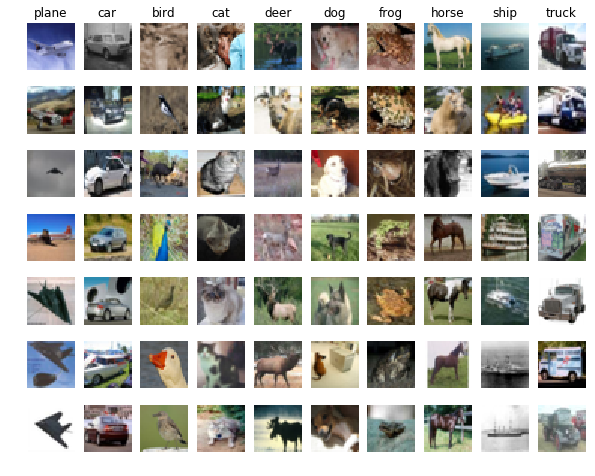

In [5]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7

# Uncomment to turn to Grayscale
# X_train = X_train.mean(axis=3)
# X_test = X_test.mean(axis=3)

for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'), cmap = plt.get_cmap('gray'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [6]:
# Subsample the data for more efficient code execution in this exercise
num_training = 10000
mask = range(num_training)   
X_train = X_train[mask]
y_train = y_train[mask] 

num_test = 10000
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

In [7]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print X_train.shape, X_test.shape

(10000, 3072) (10000, 3072)


In [8]:
# K-fold cross validation
def cross_validation(dist):
    classifier = knn.KNN()
    
    ks = np.array([1,3,5,7,9,11,15,20,50,100])
    k_validation = 5
    step = X_train.shape[0] / k_validation;
    avg_v = np.zeros(ks.shape[0])

    for idx, k in enumerate(ks):
        avg = np.zeros(k_validation)
        for i in range(0,k_validation):
            # Divide traning set to training and validation datasets
            X_valid = X_train[i*step:((i+1)*step)]
            y_valid = y_train[i*step:((i+1)*step)]
            X_cross = np.delete(X_train,np.arange(i*step,((i+1)*step)), axis = 0)
            y_cross = np.delete(y_train,np.arange(i*step,((i+1)*step)))

            # train classifier then predict using validation dataset using corresponding k
            classifier.train(X_cross,y_cross)
            y_valid_pred = classifier.predict(X_valid,dist,k)

            # calculate accuracy and record it 
            num_correct = np.sum(y_valid_pred == y_valid)
            accuracy = float(num_correct) / (step)
            avg[i] = accuracy
            plt.plot(k,avg[i],'ro')
            print 'K = %d, Fold %d: %f' % (k,i,accuracy)

        std = np.sqrt(np.mean(abs(avg - np.mean(avg))**2))
        avg = (np.sum(avg) / k_validation)
        avg_v[idx] = avg
        plt.errorbar(k, avg, xerr=0, yerr=std)
        print 'K = %d: | AVG: %f, STD: %f' % (k,avg,std)

    plt.plot(ks,avg_v, 'xb-')
    plt.show()

In [9]:
def test_KNN(k,dist):
    classifier = knn.KNN()
    # train classifier
    classifier.train(X_train,y_train)
    # Predict the labels of testing data
    y_test_pred = classifier.predict(X_test, dist, k)
    # Compute and print the fraction of correctly predicted examples
    num_correct = np.sum(y_test_pred == y_test)
    accuracy = float(num_correct) / num_test
    print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)

    # Compute Correct Classification Rate for each Class 
    histogram = np.zeros(num_classes)
    for i in range(0,num_classes):
        count = np.sum(y_test==i)
        if(count != 0): 
            histogram[i-1] = (float(np.sum(y_test_pred[np.where(y_test==i)] == i)) / count) * 100

    # Output BarChart
    index = np.arange(num_classes)
    bar_width = 0.5
    plt.bar(index,histogram,0.5)
    plt.xlabel("Classes")
    plt.ylabel("% of Correctly Classified")
    plt.xticks(index+bar_width/2,classes)
    plt.show()

In [ ]:
distance = 'L2' # distance metric for testing and/or cross-valdation
K = 7 # K used for testing 

# Uncomment this for using Cross Validaiton 
cross_validation(distance)

# Uncomment this for testing
# test_KNN(K,distance)